In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, period, alpha, beta):

    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['positions'] = 0
    signals['signals'] = 0
    signals['std'] = signals['asset'].rolling(window=20, min_periods=20).std()
    signals['mid'] = signals['asset'].rolling(window=20, min_periods=20).mean()
    signals['upper'] = signals['mid'] + 2 * signals['std']
    signals['lower'] = signals['mid'] - 2 * signals['std']
    signals['coordinates'] = ''

    # Bottom w pattern recognition
    for e in range(period, len(signals)):
        pattern_found = False

        # Top right
        if signals['asset'].iloc[e] > signals['upper'].iloc[e] and signals['positions'].iloc[e] == 0:
            for c in range(e, e-period, -1):
                
                # Middle
                if np.abs(signals['mid'].iloc[c]-signals['asset'].iloc[c]) < alpha and np.abs(signals['mid'].iloc[c] - signals['upper'].iloc[e]) < alpha:
                    for b in range(c, e-period, -1):
                        
                        # Bottom left
                        if np.abs(signals['lower'].iloc[b]-signals['asset'].iloc[b]) < alpha:
                            for a in range(b, e-period, -1):
                                
                                # Top left
                                if signals['mid'].iloc[a] < signals['asset'].iloc[a]:
                                    for d in range(e, c, -1):
                                        
                                        # Bottom right
                                        if signals['asset'].iloc[d] - signals['lower'].iloc[d] < alpha and signals['asset'].iloc[d] > signals['lower'].iloc[d] and signals['asset'].iloc[d] < signals['asset'].iloc[b]:
                                            signals.at[signals.index[e],'signals'] = 1
                                            signals.at[signals.index[e],'coordinates']=f'{a},{b},{c},{d},{e}'
                                            signals['positions']=signals['signals'].cumsum()
                                            pattern_found=True
                                            break
                                    break
                            break
                    break

        # Exit position based on expansion/contraction trigger
        if signals['positions'].iloc[e] != 0 and signals['std'].iloc[e] < beta and not pattern_found:
            signals.at[signals.index[e],'signals'] = -1
            signals['positions']=signals['signals'].cumsum()
    
    return signals

In [3]:
def plot(signals, ticker):
    
    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('Bollinger Bands', pad=15)
    plt.grid(True)
    plt.show()

    # Bollinger bands
    plt.figure(figsize=(11,7))
    bands = plt.fill_between(signals.index,signals['lower'], signals['upper'], alpha=0.2, color='C1')
    ma, = plt.plot(signals['mid'], linestyle='--', alpha=0.6, c='C2')

    # Bottom w patterns
    patterns = signals['coordinates'][signals['signals']==1]
    for i in range(len(patterns)):
        indexlist = list(map(int,patterns[patterns.index[i]].split(',')))
        bottom_w, = plt.plot(signals['asset'].iloc[indexlist].index, signals['asset'].iloc[indexlist], lw=5, alpha=0.7, c='C6')

    plt.legend([bands, ma, bottom_w], ['2 Sigma', 'Moving Average', 'Bottom W Pattern'], loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Price', labelpad=15)
    plt.title('Bollinger Bands', pad=15)
    plt.grid(True)
    plt.show()

In [4]:
def BollingerBands(ticker, start_date, end_date, capital):
    
    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Default bottom w pattern horizon, price difference trigger, and expansion/contraction trigger
    signals = signal_generation(asset, 100, 0.1, 0.05)
    
    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'Bollinger Bands'), signals, start_date, end_date, capital)

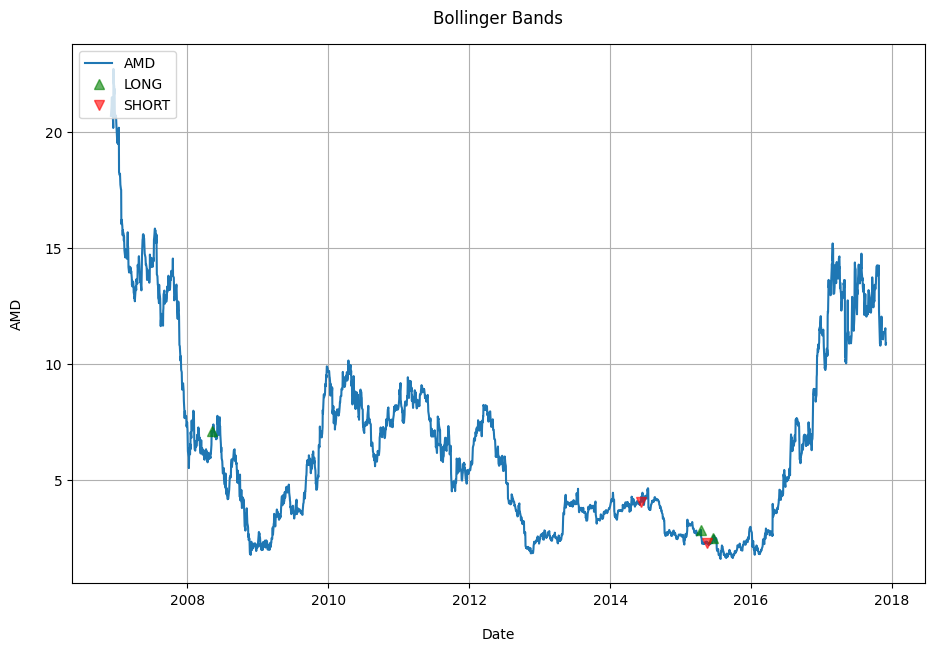

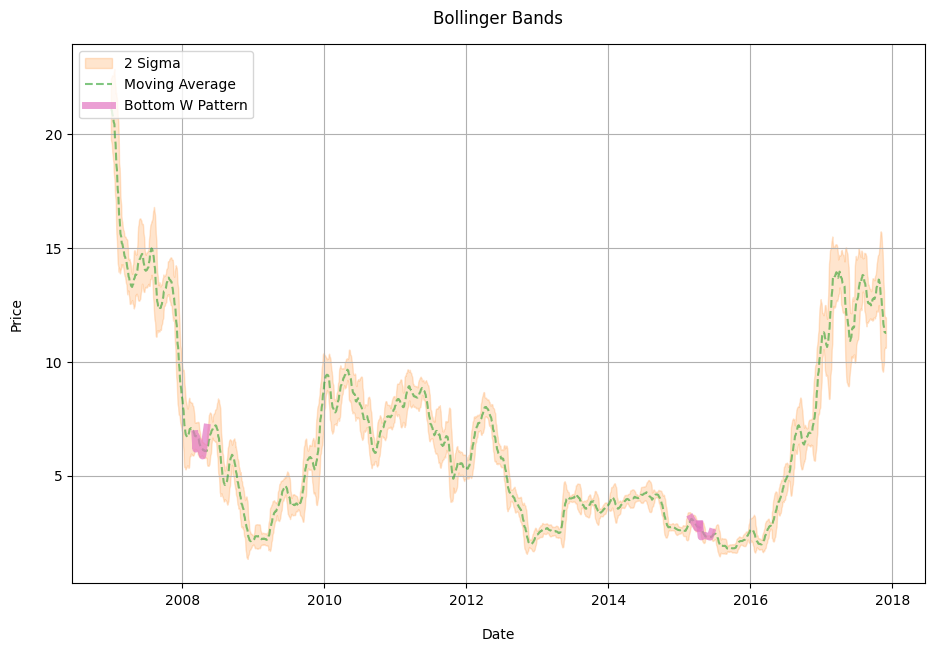

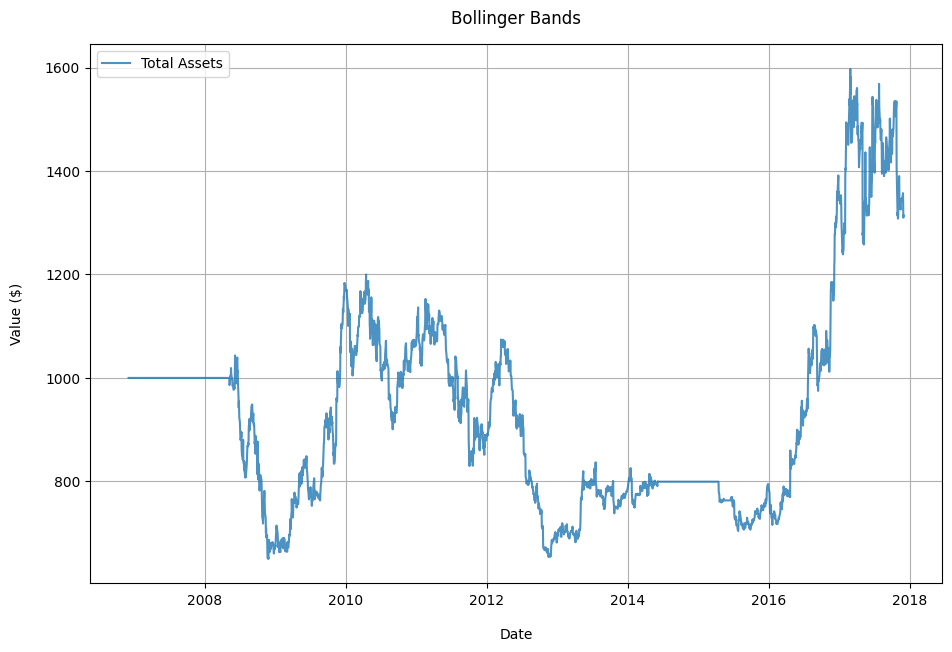

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.313816,0.890278,0.000099,-0.009954,-0.455044,-0.000217,434.8,62.763168


In [5]:
BollingerBands('AMD', '2006-12-01', '2017-12-01', 1000)